# Домашняя работа №3
## Выполнила Елизавета Клыкова, БКЛ181
### Импорт библиотек

In [1]:
# !pip install transformers

In [2]:
import random
import time
import datetime

import numpy as np
import pandas as pd

from math import sqrt
from tqdm.auto import tqdm

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset,\
    RandomSampler, SequentialSampler

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from keras.preprocessing.sequence import pad_sequences

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
seed = 117
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True

## BERT
Я перенесла нужные ячейки в эту тетрадку вместо того, чтобы запускать исходную (мне кажется, так легче воспринимать код и внесенные изменения).

#### Загрузка

In [4]:
data = pd.read_csv('../input/answers-subsample/answers_subsample.csv')
cat_mapper = {cat: n for n, cat in enumerate(data.category.unique())}
data.category = data.category.map(cat_mapper)

In [5]:
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased',
                                          do_lower_case=True)

Loading BERT tokenizer...


Downloading:   0%|          | 0.00/851k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.64M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [6]:
sentences = data.text.values
labels = data.category.values

In [7]:
# Print the original sentence.
print('Original: ', sentences[0])
print()

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))
print()

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(
    tokenizer.tokenize(sentences[0])))

Original:  Могут ли в россельхозбанке дать в залог норковых шуб помогите пожалуйста

Tokenized:  ['могут', 'ли', 'в', 'рос', '##сель', '##хо', '##з', '##бан', '##ке', 'да', '##ть', 'в', 'зал', '##ог', 'но', '##рк', '##овых', 'ш', '##уб', 'пом', '##оги', '##те', 'по', '##жал', '##уи', '##ста']

Token IDs:  [22553, 23029, 309, 26673, 80686, 37489, 11637, 42572, 11827, 10448, 11569, 309, 53932, 19820, 11299, 53464, 20565, 330, 58675, 86074, 60338, 10740, 10291, 28704, 62848, 15294]


#### Токенизация + индексация

In [8]:
# Tokenize all of the sentences and map the tokens to their word IDs.
input_ids = []

# For every sentence...
for sent in tqdm(sentences):
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens=True,  # Add '[CLS]' and '[SEP]'

                        # This function also supports truncation and conversion
                        # to pytorch tensors, but we need to do padding, so we
                        # can't use these features :( .
                        # max_length = 128,          # Truncate all sentences.
                        # return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

  0%|          | 0/237779 [00:00<?, ?it/s]

Original:  Могут ли в россельхозбанке дать в залог норковых шуб помогите пожалуйста
Token IDs: [101, 22553, 23029, 309, 26673, 80686, 37489, 11637, 42572, 11827, 10448, 11569, 309, 53932, 19820, 11299, 53464, 20565, 330, 58675, 86074, 60338, 10740, 10291, 28704, 62848, 15294, 102]


#### Паддинг

In [9]:
print('Max sentence length:', max([len(sen) for sen in input_ids]))

Max sentence length: 97


In [10]:
# Set the maximum sequence length to 97.
MAX_LEN = 97

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token,
                                               tokenizer.pad_token_id))

# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence,
# as opposed to the beginning.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long",
                          value=0, truncating="post", padding="post")

print('\nDone.')


Padding/truncating all sentences to 97 values...

Padding token: "[PAD]", ID: 0

Done.


#### Attention-маски

In [11]:
# Create attention masks
attention_masks = []

# For each sentence...
for sent in tqdm(input_ids):

    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]

    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

  0%|          | 0/237779 [00:00<?, ?it/s]

#### Делим датасет
Тут будет финт ушами: нужно урезать обучающую выборку, чтобы не ждать выполнения кода до завтра, но не урезать валидационную выборку. Сократим трейновые данные в два раза (с 90% до 45% от общего объема).

In [12]:
# Use 45% for training and 10% for validation.
train_inputs, val_inputs, train_labels, val_labels = \
    train_test_split(input_ids, labels, random_state=seed,
                     test_size=0.1, train_size=0.45)

# Do the same for the masks.
train_masks, val_masks, _, _ = train_test_split(attention_masks, labels,
                                                random_state=seed,
                                                test_size=0.1,
                                                train_size=0.45)

#### Конвертация в тензоры

In [13]:
# Convert all inputs and labels into torch tensors,
# the required datatype for our model.
train_inputs = torch.tensor(train_inputs)
val_inputs = torch.tensor(val_inputs)

train_labels = torch.tensor(train_labels)
val_labels = torch.tensor(val_labels)

train_masks = torch.tensor(train_masks)
val_masks = torch.tensor(val_masks)

In [14]:
# The DataLoader needs to know our batch size for training,
# so we specify it here.
# For fine-tuning BERT on a specific task,
# the authors recommend a batch size of 16 or 32.

batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler,
                              batch_size=batch_size)

# Create the DataLoader for our validation set.
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler,
                            batch_size=batch_size)

### Обучение

In [15]:
# Load BertForSequenceClassification, the pretrained BERT model with a single
# linear classification layer on top.
model = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-uncased",  # 12-layer model with an uncased vocab
    num_labels=len(data.category.unique()),  # The number of output labels
    output_attentions=False,  # Whether the model returns attentions weights.
    output_hidden_states=False,  # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Downloading:   0%|          | 0.00/641M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [16]:
b = model.bert.pooler.dense.weight
c = model.classifier.weight
b = b.cpu().detach().numpy()
c = c.cpu().detach().numpy()

In [17]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print(
    'The BERT model has {:} different named parameters.\n'.format(
        len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (105879, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              

#### Optimizer & Scheduler

In [18]:
# AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr=2e-5,  # args.learning_rate - default is 5e-5
                  eps=1e-8  # args.adam_epsilon  - default is 1e-8
                  )

In [19]:
# Number of training epochs (authors recommend between 2 and 4)
epochs = 3

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=100,
                                            num_training_steps=total_steps)

### Training loop
#### Подсчет ошибки
В оригинальной тетрадке accuracy, мы возьмем f1, чтобы метрики были сравнимы.

In [20]:
# Function to calculate the f1 of our predictions vs labels
def flat_f1_score(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(pred_flat, labels_flat, average='micro')

In [21]:
def format_time(elapsed):
    """
    Takes a time in seconds and returns a string hh:mm:ss
    """
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [22]:
device = torch.device('cuda') if torch.cuda.is_available()\
    else torch.device('cpu')

In [24]:
# Seed мы задали в самом начале, он не такой, как у авторов
# Но у нас и данные другие
torch.cuda.manual_seed_all(seed)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(
        epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode.
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            # Report progress.
            print(
                '  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(
                    step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Сlear any previously calculated gradients before performing a
        # backward pass.
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        labels=b_labels)

        # The call to `model` always returns a tuple, so we need to pull the
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(
        format_time(time.time() - t0)))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch,
    # measure our performance on our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode.
    model.eval()

    # Tracking variables
    eval_loss, eval_f1 = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in val_dataloader:

        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)

        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss
            # because we have not provided labels.
            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask)

        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the f1 for this batch of test sentences.
        tmp_eval_f1 = flat_f1_score(logits, label_ids)

        # Accumulate the total f1.
        eval_f1 += tmp_eval_f1

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final f1 for this validation run.
    print("  F1 score: {0:.2f}".format(eval_f1/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 3 ========
Training...
  Batch    40  of  3,344.    Elapsed: 0:00:13.
  Batch    80  of  3,344.    Elapsed: 0:00:26.
  Batch   120  of  3,344.    Elapsed: 0:00:38.
  Batch   160  of  3,344.    Elapsed: 0:00:51.
  Batch   200  of  3,344.    Elapsed: 0:01:04.
  Batch   240  of  3,344.    Elapsed: 0:01:17.
  Batch   280  of  3,344.    Elapsed: 0:01:29.
  Batch   320  of  3,344.    Elapsed: 0:01:42.
  Batch   360  of  3,344.    Elapsed: 0:01:55.
  Batch   400  of  3,344.    Elapsed: 0:02:08.
  Batch   440  of  3,344.    Elapsed: 0:02:21.
  Batch   480  of  3,344.    Elapsed: 0:02:33.
  Batch   520  of  3,344.    Elapsed: 0:02:46.
  Batch   560  of  3,344.    Elapsed: 0:02:59.
  Batch   600  of  3,344.    Elapsed: 0:03:12.
  Batch   640  of  3,344.    Elapsed: 0:03:24.
  Batch   680  of  3,344.    Elapsed: 0:03:37.
  Batch   720  of  3,344.    Elapsed: 0:03:50.
  Batch   760  of  3,344.    Elapsed: 0:04:03.
  Batch   800  of  3,344.    Elapsed: 0:04:15.
  Batch   840  of

Качество ровно такое же, как в нашей улучшенной модели :)

Визуализируем процесс обучения для полноты картины.

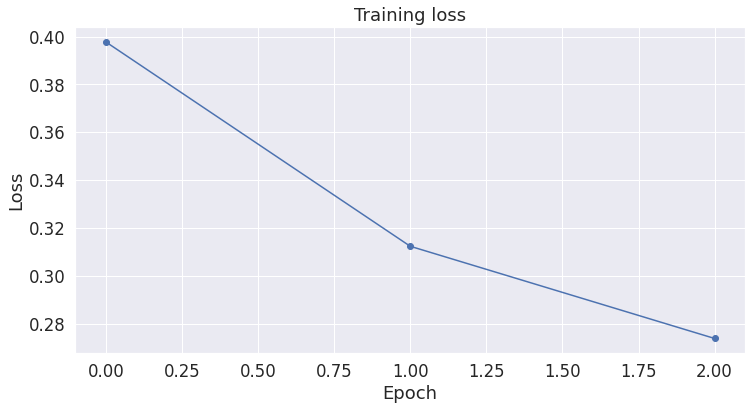

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12, 6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()